توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




در جابجایی نسبت به تصویر اصلی به اندازه ای رندوم بالا تر یا پایین تر در نظر گرفته شدند.
در چرخش ابتدا طبق ماتریس چرخش، محل پیکسل ها را تغییر می دهیم و مقدار متناظر آن ها را قرار می دهیم و بعد از آن برای از بین بردن ناحیه سیاه یک تابع تعریف می کنیم (در واقع یک مسئله بهینه سازی حل شده است که با یک ابعاد مشخص تصویر و زاویه آن بیشترین مساحت برش چه مقدار خواهد بود.)

در تغییر مقیاس برش را به اندازه ی متفاوتی از تصویر اصلی انجام می دهیم و آن را به سایز تصویر اصلی ریسایز می کنی.

In [3]:
# function 1
def displacement(img):
  height, width = img.shape[:2]
  # print(height,width,"<",end="")
  h_center, w_center = int(np.ceil(height/2)), int(np.ceil(width/2))
  hh, ww = [224,height-224], [224,width-224]
  min_c_h, min_c_w = min(224,height-224) ,min(224,width-224)
  hidx, widx = hh.index(min_c_h), ww.index(min_c_w) #finding the limmiter of size for chosing the center range
  if hidx==0:
    cxh = random.randint(max(h_center-112,112), h_center-56) if random.choice([True, False]) else random.randint(h_center+56, min(h_center+112,height-112))
  else:
    cxh = random.randint(112, 56 + h_center//2) if random.choice([True, False]) else random.randint(int(.75*height-56), height-112)

  if widx==0:
    cxw = random.randint(max(w_center-112,112), w_center-56) if random.choice([True, False]) else random.randint(w_center+56, min(w_center+112,width-112))
  else:
    cxw = random.randint(112, 56 + w_center//2) if random.choice([True, False]) else random.randint(int(.75*width-56), width-112)
  img = img[cxh-112:cxh+112, cxw-112:cxw+112]
  # print(cxh-112,cxh+112,"><" ,cxw-112,cxw+112,"> imsize = ",img.shape,cxh,cxw)

  return img

# function 2
def rotation(image):
  """
  resource : https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
  Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
  (in degrees). The returned image will be large enough to hold the entire
  new image, with a black background
  """
  angle = random.uniform(-100, -30) if random.choice([True, False]) else random.uniform(30, 100)
  # Get the image size
  # No that's not an error - NumPy stores image matricies backwards
  image_size = (image.shape[1], image.shape[0])
  image_center = tuple(np.array(image_size) / 2)
  image_height, image_width = image.shape[0:2]
  h,w = image_height,image_width
  # Convert the OpenCV 3x2 rotation matrix to 3x3
  rot_mat = np.vstack(
      [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
  )
  # print("rot_mat=",rot_mat)
  rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

  # Shorthand for below calcs
  image_w2 = image_size[0] * 0.5
  image_h2 = image_size[1] * 0.5

  # Obtain the rotated coordinates of the image corners
  rotated_coords = [
      (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
      (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
      (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
      (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
  ]

  # Find the size of the new image
  x_coords = [pt[0] for pt in rotated_coords]
  x_pos = [x for x in x_coords if x > 0]
  x_neg = [x for x in x_coords if x < 0]

  y_coords = [pt[1] for pt in rotated_coords]
  y_pos = [y for y in y_coords if y > 0]
  y_neg = [y for y in y_coords if y < 0]

  right_bound = max(x_pos)
  left_bound = min(x_neg)
  top_bound = max(y_pos)
  bot_bound = min(y_neg)

  new_w = int(abs(right_bound - left_bound))
  new_h = int(abs(top_bound - bot_bound))

  # We require a translation matrix to keep the image centred
  trans_mat = np.matrix([
      [1, 0, int(new_w * 0.5 - image_w2)],
      [0, 1, int(new_h * 0.5 - image_h2)],
      [0, 0, 1]
  ])

  # Compute the tranform for the combined rotation and translation
  affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

  # Apply the transform
  image = cv2.warpAffine(
      image,
      affine_mat,
      (new_w, new_h),
      flags=cv2.INTER_LINEAR
  )

  """
  Given a rectangle of size wxh that has been rotated by 'angle' (in
  radians), computes the width and height of the largest possible
  axis-aligned rectangle within the rotated rectangle.

  Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

  Converted to Python by Aaron Snoswell
  largest_rotated_rect(w, h, angle)
  """
  angle = np.radians(angle)
  quadrant = int(np.floor(angle / (np.pi / 2))) & 3
  sign_alpha = angle if ((quadrant & 1) == 0) else np.pi - angle
  alpha = (sign_alpha % np.pi + np.pi) % np.pi

  bb_w = w * np.cos(alpha) + h * np.sin(alpha)
  bb_h = w * np.sin(alpha) + h * np.cos(alpha)

  gamma = np.arctan2(bb_w, bb_w) if (w < h) else np.arctan2(bb_w, bb_w)

  delta = np.pi - alpha - gamma

  length = h if (w < h) else w

  d = length * np.cos(alpha)
  a = d * np.sin(alpha) / np.sin(delta)

  y = a * np.cos(gamma)
  x = y * np.tan(gamma)


  width = bb_w - 2 * x
  height = bb_h - 2 * y

  """
  Given a NumPy / OpenCV 2 image, crops it to the given width and height,
  around it's centre point
  crop_around_center(image, width, height)
  """

  image_size = (image.shape[1], image.shape[0])
  image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))
  # print(width)
  if(width > image_size[0]):
      width = image_size[0]

  if(height > image_size[1]):
      height = image_size[1]

  x1 = int(image_center[0] - width * 0.5)
  x2 = int(image_center[0] + width * 0.5)
  y1 = int(image_center[1] - height * 0.5)
  y2 = int(image_center[1] + height * 0.5)
  img = image[y1:y2, x1:x2]
  img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_LINEAR)

  return img


# function 3
def scaling(img):
  h,w = img.shape[:2]
  ch, cw = h//2, w//2
  rnd_h, rnd_w = randint(25,50),randint(25,40)
  img = img[ch-112+rnd_h:ch+112-rnd_h, cw-112+rnd_w:cw+112-rnd_w]
  img = cv2.resize(img, (224, 224),
               interpolation = cv2.INTER_LINEAR)

  return img



# function 4
def Brightness(img):  ## for augmentation
  if img is None:
        raise ValueError("Input image is None")

  image_orig = np.copy(img)

  if image_orig.dtype != np.uint8:
      raise ValueError("Input image should be of type np.uint8")

  brightness = random.randint(30, 60)

  image_orig = image_orig.astype(np.int16) + brightness
  img = np.clip(image_orig.astype(np.int16), 0, 255).astype(np.uint8)

  return img



# function 5
def bluring(img):# for augmentation
  ksize = (random.randint(5, 10), random.randint(5, 10))
  # Using cv2.blur() method
  img = cv2.blur(img, ksize)

  return img

# function 6
def gaussian_noise(img):#for augmentation
  mean=0
  sigma=random.uniform(1, 2)
  row, col, ch = img.shape
  gauss = np.random.normal(mean, sigma, (row, col, ch)).astype(np.uint8)
  img = cv2.add(img, gauss)

  return img





برای نوشتن کلاس دیتاست، ابتدا مسیر ها را برای آموزش، ارزیابی یا تست را می دهیم.سپس برای داده های آموزش یک آگمنتیشن به صورت رندوم از بین 3 آگمنتیشن تعریف شده انتخاب می کنیم . تصاویر گراند تروث را داریم . حال روی آن ها ترنسفورم های تعریف شده را انجام می دهیم و لیبل گذاری می کنیم.

در نهایت آن ها را با انوتیشن مناسب ذخیره شده ، در هارد ذخیره می کنیم

چون حجم این دیتا بسیار زیاد است، آن را نمی توانستیم روی رم ذخیره کنیم. همچنین به صورت on the go هم بسیار زمان بر بود.

In [5]:
from tqdm import tqdm
class CustomDataset(Dataset):

    def __init__(self,train_val_test = 0):
        self.train_val_test = train_val_test
        if train_val_test == 0:
          txt_file = '/content/ADEChallengeData2016/sceneCategories.txt'
          self.root_dir = "/content/ADEChallengeData2016/images/training"
          self.x1_dir = "/content/training_dataset/x1/"
          self.x2_dir = "/content/training_dataset/x2/"
          self.lbls_dir = "/content/training_dataset/lbls/"
          with open(txt_file, 'r') as file:
            img_names = [line.split()[0] for line in file if line.split()[0].startswith("ADE_train")]
        elif train_val_test == 1:
          txt_file = '/content/ADEChallengeData2016/sceneCategories.txt'
          self.root_dir = "/content/ADEChallengeData2016/images/validation"
          with open(txt_file, 'r') as file:
            img_names = [line.split()[0] for line in file if line.split()[0].startswith("ADE_val")]
          self.x1_dir = "/content/validation_dataset/x1/"
          self.x2_dir = "/content/validation_dataset/x2/"
          self.lbls_dir = "/content/validation_dataset/lbls/"
        elif train_val_test == 2:
          txt_file = '/content/release_test/list.txt'
          self.root_dir = "/content/release_test/testing"
          self.x1_dir = "/content/test_dataset/x1/"
          self.x2_dir = "/content/test_dataset/x2/"
          self.lbls_dir = "/content/test_dataset/lbls/"
          with open(txt_file, 'r') as file:
            img_names = [line.split()[0] for line in file]
        # create the directory if it doesn't exist
        if not os.path.exists(self.x1_dir):
          os.makedirs(self.x1_dir)
        if not os.path.exists(self.x2_dir):
          os.makedirs(self.x2_dir)
        if not os.path.exists(self.lbls_dir):
          os.makedirs(self.lbls_dir)
        self.mains = []
        self.changed =[]
        self.lbls = []
        self.annotations = img_names[:min(len(img_names),16000)]  #because of shortage of space we select the 16000 of train data with augmentation
        self.number_of_aug = 3
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize
            ])
        print("generating the dataset!...")
        for img_name in tqdm(self.annotations):# MAKING THE DATASET(it used to be on the go in the __get_item__ but it took so much time while training!!!)
          if self.train_val_test == 2:
            img_path = self.root_dir+"/"+img_name
          else:
            img_path = self.root_dir+"/"+img_name+".jpg"
          # print(img_path)
          image = IM(img_path)
          # plt.imshow(image)
          h,w = image.shape[:2]
          while h<240 or w<240:    #to make sure the image is big enough for transformations
            image=cv2.resize(image, (2*h, 2*w), interpolation = cv2.INTER_LINEAR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h,w = image.shape[:2]
            # print("resized",h,w,end= "")
            # plt.imshow(image)
            # plt.show()
          ch,cw = h//2,w//2
          images=[]
          labels=[]

          images.append(image)
          augment_functions = random.choice([Brightness, bluring, gaussian_noise])
          if self.train_val_test == 0:    #augmentation only for training set
            images.append(augment_functions(image))
          transformed_images = []
          main_images = []
          transform_idx = [0    ,     1      , 2  ]
          transform_list = [displacement, rotation, scaling]
          for img_ in images:
            main_images.append(self.transform(img_[ch-112:ch+112,cw-112:cw+112]))
            if random.random()>0.3:   #making the random decide that it has one transformation or 2

              idx_choice = random.choice(transform_idx)
              transform = transform_list[idx_choice]
              transformed_images.append(self.transform(transform(img_)))
              # making the transformed_images label
              label = [int(idx_choice==2), int(idx_choice==1), int(idx_choice==0)]
              labels.append(label)
            else:
              idx_choice = random.sample(transform_idx, 2)
              transform1 = transform_list[idx_choice[0]]
              transform2 = transform_list[idx_choice[1]]
              transformed_images.append(self.transform(transform2(transform1(img_))))
              # making the transformed_images label
              label = [int(idx_choice[0]==2 or idx_choice[1]==2), int(idx_choice[0]==1 or idx_choice[1]==1),
                      int(idx_choice[0]==0 or idx_choice[1]==0)]
              labels.append(label)
            # print("idx=",idx_choice)

          torch.save(torch.stack(main_images), self.x1_dir+img_name+".pth")
          # self.mains.append(torch.stack(main_images))
          torch.save(torch.stack(transformed_images), self.x2_dir+img_name+".pth")
          # self.changed.append(torch.stack(transformed_images))
          torch.save(torch.tensor(labels), self.lbls_dir+img_name+".pth")
          # self.lbls.append(torch.tensor(labels))




    def __getitem__(self,idx):
        idx = idx % len(self.annotations)
        img_name = self.annotations[idx]
        x1, x2 = torch.load(self.x1_dir+img_name+".pth"), torch.load(self.x2_dir+img_name+".pth")
        lbls = torch.load(self.lbls_dir + img_name + ".pth")
        return (x1, x2, lbls)

    def __len__(self):
      return len(self.annotations)
      #


In [6]:
batch_size = 8

!rm /content/ADEChallengeData2016.zip
!rm /content/release_test.zip

dataset_train = CustomDataset(train_val_test = 0)## To Do
dataset_val = CustomDataset(train_val_test = 1)## To Do
# free up the space!
!rm -r /content/ADEChallengeData2016
dataset_test = CustomDataset(train_val_test = 2)## To Do
!rm -r /content/release_test


train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)## To Do
test_loader= DataLoader(dataset_test, batch_size=batch_size, shuffle=True)## To Do
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)## To Do


generating the dataset!...


100%|██████████| 16000/16000 [08:25<00:00, 31.67it/s]


generating the dataset!...


100%|██████████| 2000/2000 [00:27<00:00, 71.83it/s]


generating the dataset!...


100%|██████████| 3352/3352 [00:53<00:00, 62.86it/s]


plotting the training dataset


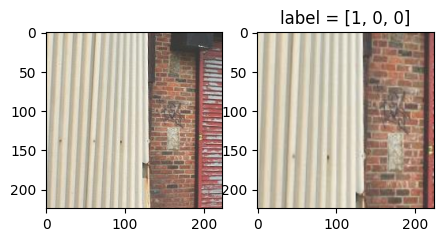

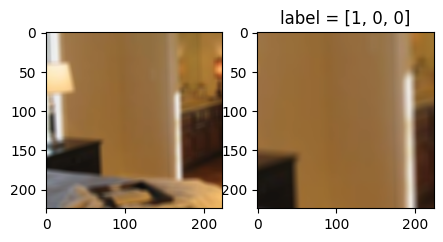

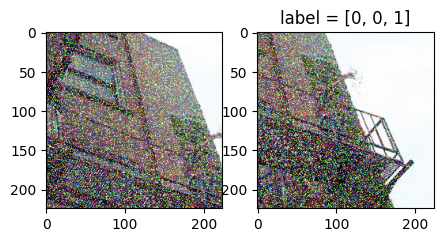

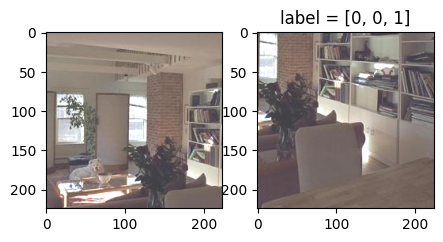

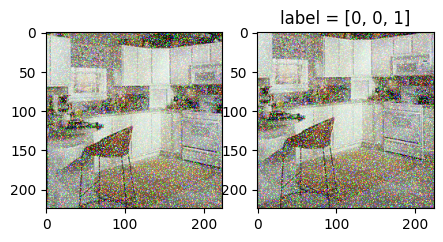

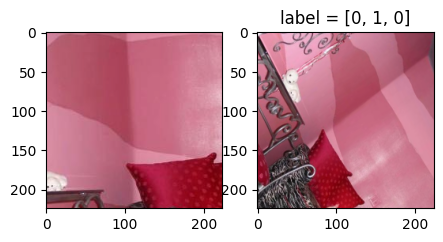

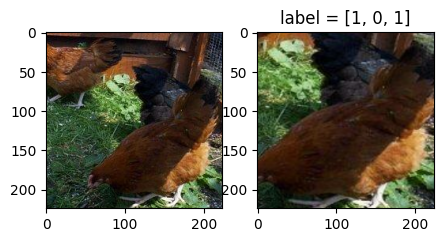

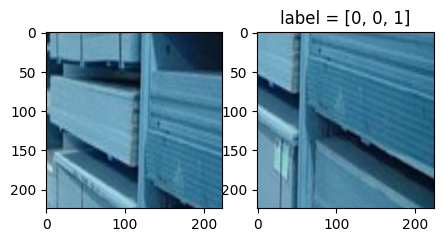

plotting the test dataset


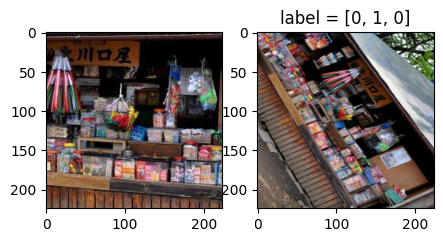

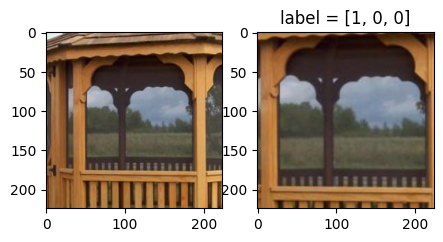

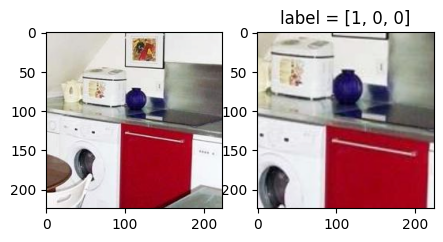

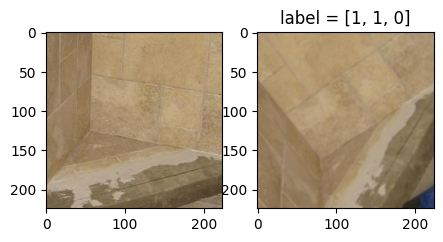

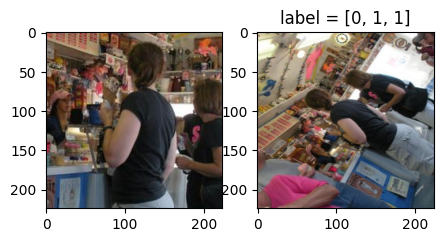

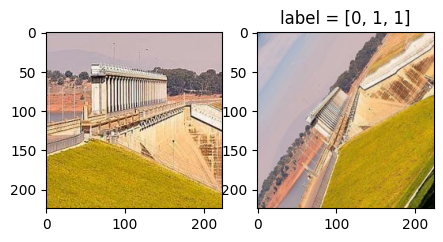

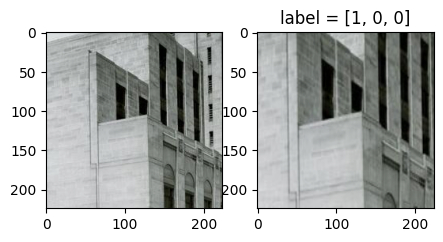

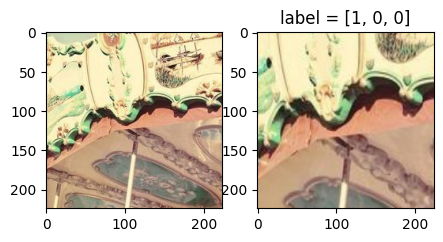

In [7]:
## To Do  : show 8 images from train_loader & 8 images from test_loader

from PIL import Image

# Use DataLoader to handle batching and shuffling
def visualize_data(data_loader, train_val_test):

  if train_val_test==0:
    augment_batch = 2
  else:
    augment_batch = 1

  batch = next(iter(data_loader))
  main_images, transformed_images,label = batch
  main_images = main_images.view(batch_size*augment_batch,3,224,224)
  transformed_images = transformed_images.view(batch_size*augment_batch,3,224,224)
  label = label.view(batch_size*augment_batch, 3)
  # print(main_images.shape)
  # Denormalize the images if they were normalized in the data transformation step
  # Define the mean and standard deviation used for normalization
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]

  # Invert the normalization to display the images
  inv_normalize = transforms.Normalize(
      mean=[-m/s for m, s in zip(mean, std)],
      std=[1/s for s in std]
  )

  # Plot the images from the batch
  for i in range(batch_size):
    plt.figure(figsize=(5, 5))
    i = augment_batch*i+random.randint(0,augment_batch-1)
    lb = label[i]
    plt.subplot(121)
    image1 = main_images[i]  # Get one image from the batch

    image1 = inv_normalize(image1)  # Invert the normalization
    image1 = transforms.ToPILImage()(image1)  # Convert to PIL Image
    b, g, r = image1.split()
    image1 = Image.merge("RGB", (r, g, b))
    plt.imshow(image1)

    plt.subplot(122)
    image2 = transformed_images[i]  # Get one image from the batch
    # print(image2.shape)
    image2 = inv_normalize(image2)  # Invert the normalization
    image2 = transforms.ToPILImage()(image2)  # Convert to PIL Image
    b, g, r = image2.split()
    image2 = Image.merge("RGB", (r, g, b))
    plt.imshow(image2)
    plt.title("label = "+str(lb.tolist()))
    plt.show()

print("plotting the training dataset")
visualize_data(train_loader, train_val_test=0)

print("plotting the test dataset")
visualize_data(test_loader, train_val_test=2)

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

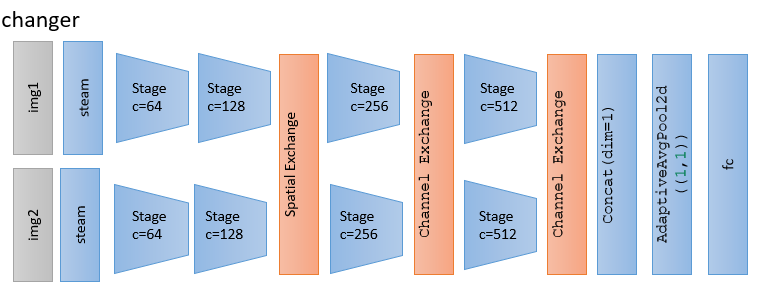

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


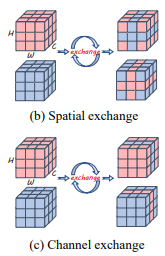

In [8]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

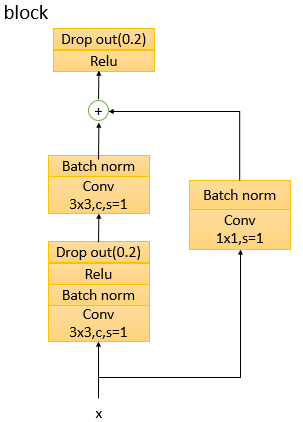

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))-->
 padding(conv) = 1

2.  دلیل استفاده از کانولوشن 1در1 چیست؟

یکی کردن تعداد کانال ها



In [9]:
##To Do
class block(nn.Module):
  def __init__(self,in_channels, out_channels):
    super(block,self).__init__()
    self.conv1 = nn.Conv2d(
            in_channels,out_channels,
            kernel_size=3,stride=1,
            padding=1)
    self.conv2 = nn.Conv2d(
            out_channels,out_channels,
            kernel_size=3,stride=1,
            padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)


  def forward(self,x):
    x_identity = x.clone()
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.conv2(x)
    x = self.bn1(x)

    x = x + self.bn1(self.conv1(x_identity))

    x = self.relu(x)
    out = self.dropout(x)

    return out

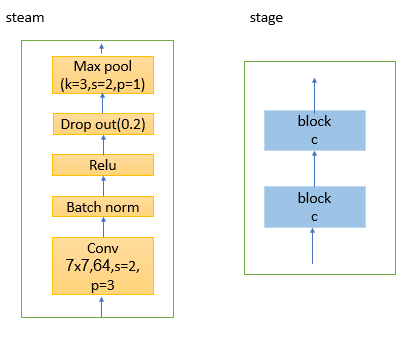

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [10]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    self.stage1=self._make_stage(block,64,64)
    self.stage2=self._make_stage(block,64,128)
    self.stage3=self._make_stage(block,128,256)
    self.stage4=self._make_stage(block,256,512)

    self.SE = SpatialExchange()
    self.CE = ChannelExchange()

    self.adaptive_avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.fc = nn.Linear(512, 3)



  def _make_stage(self,block,in_channels, out_channels):

    layers=[]
    layers.append(block(in_channels, out_channels))
    layers.append(block(out_channels, out_channels))
    return nn.Sequential(*layers)




  def forward(self,x1,x2):
    x1 = self.steam(x1)
    x2 = self.steam(x2)

    x1 = self.stage1(x1)
    x2 = self.stage1(x2)
    # print("a1",x1.shape)
    x1 = self.stage2(x1)
    x2 = self.stage2(x2)

    x1,x2 = self.SE(x1, x2)

    x1 = self.stage3(x1)
    x2 = self.stage3(x2)

    x1,x2 = self.CE(x1, x2)
    # print(x1.shape)
    x = torch.cat((x1, x2), 1)
    # print(x.shape)
    x = self.adaptive_avgpool(x)

    # print(x.shape)
    # flatten the tensor for fully connected layers
    x = x.view(-1, 512)
    out = self.fc(x)






    return out

In [11]:
from tqdm import tqdm
## To Do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-3
BATCH_SIZE = 8
NUM_EPOCHS = 4
augment_batch = 2


ResidualBlock = block
model=changer(ResidualBlock,SpatialExchange,ChannelExchange).to(device)

citeration = nn.BCEWithLogitsLoss()
optimizer= optim.Adam(model.parameters(), lr=LEARNING_RATE)



##Train & validation


training epoch :  1 ...


100%|██████████| 2000/2000 [18:02<00:00,  1.85it/s, loss=0.437]


training epoch :  2 ...


100%|██████████| 2000/2000 [18:15<00:00,  1.83it/s, loss=0.436]


training epoch :  3 ...


100%|██████████| 2000/2000 [18:43<00:00,  1.78it/s, loss=0.436]


training epoch :  4 ...


100%|██████████| 2000/2000 [18:51<00:00,  1.77it/s, loss=0.435]


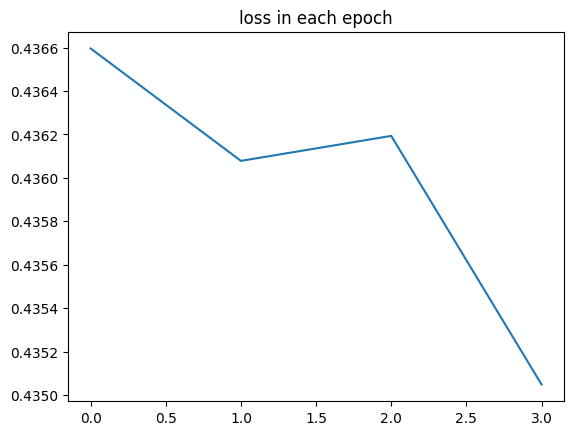

In [17]:


file_path = '/content/model.pth'
if os.path.exists(file_path):
  model = torch.load(file_path)
Loss_train=[]
Loss_val=[]
# checking if the model overfits on one single batch or not --> it did.
# main_images,transformed_images, targets = next(iter(train_loader))
# batch_trained += 1
# augment_batch_size = main_images.shape[0]
# main_images = main_images.to(device=device)
# transformed_images = transformed_images.to(device=device)
# targets = targets.float().to(device=device)
# main_images = main_images.view(augment_batch_size*augment_batch,3,224,224)
# transformed_images = transformed_images.view(augment_batch_size*augment_batch,3,224,224)
# targets = targets.view(augment_batch_size*augment_batch, 3)
loss_list =[]
for epoch in range(NUM_EPOCHS):
  model.train()
  tr_loss = 0
  batch_trained = 0
  print("training epoch : ", epoch+1, "...")
  loop = tqdm(train_loader)
  for batch_idx, (main_images,transformed_images, targets) in enumerate(loop):
      batch_trained += 1
      augment_batch_size = main_images.shape[0]
      main_images = main_images.to(device=device)
      transformed_images = transformed_images.to(device=device)
      targets = targets.float().to(device=device)
      main_images = main_images.view(augment_batch_size*augment_batch,3,224,224)
      transformed_images = transformed_images.view(augment_batch_size*augment_batch,3,224,224)
      targets = targets.view(augment_batch_size*augment_batch, 3)

      # forward
      predictions = model(main_images,transformed_images)
      loss = citeration(predictions, targets.float())

      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      Loss_train.append(loss.item())
      tr_loss = loss.item() + tr_loss
      # update tqdm loop
      loop.set_postfix(loss=tr_loss/batch_trained)
  torch.save(model, "model.pth")
  torch.save(model.state_dict(), 'model_state_dict.pth')
  loss_list.append(tr_loss/batch_trained)


# print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')
model_state_dict = model.state_dict()
optimizer_state_dict = optimizer.state_dict()
epoch = 10
loss = loss_test

# Create a dictionary
checkpoint = {
    'model_state_dict': model_state_dict,
    'optimizer_state_dict': optimizer_state_dict,
    'epoch': epoch,
    'loss': loss
}
torch.save(checkpoint,'/content/checkpoint.pth')

plt.plot(np.arange(NUM_EPOCHS), loss_list)
plt.title("loss in each epoch")
plt.show()

In [28]:

def sum_loss_accuracy(loader, model, train_val_test):
  Loss_list=[]
  if train_val_test==0:
    augment_batch = 2
  else:
    augment_batch = 1
  loop = tqdm(loader)
  model.eval()
  sigmoid = nn.Sigmoid()
  num_correct = 0
  num_preds = 0
  num_batch = 0
  total_loss = 0
  threshold = 0.5
  with torch.no_grad():
    for batch_idx, (main_images,transformed_images, targets) in enumerate(loop):
        augment_batch_size = main_images.shape[0]
        main_images = main_images.to(device=device)
        transformed_images = transformed_images.to(device=device)
        targets = targets.float().unsqueeze(1).to(device=device)
        main_images = main_images.view(augment_batch_size*augment_batch,3,224,224)
        transformed_images = transformed_images.view(augment_batch_size*augment_batch,3,224,224)
        targets = targets.view(augment_batch_size*augment_batch, 3)

        # forward
        predictions = model(main_images,transformed_images)
        loss = citeration(predictions, targets.float())
        probabilities = sigmoid(predictions)
        preds = (probabilities >= threshold).float()

        num_batch += main_images.shape[0]
        num_correct += (preds == targets).sum()
        num_preds += torch.numel(preds)
        Loss_list.append(loss.item())
        total_loss += loss
        # update tqdm loop
        loop.set_postfix(loss=((total_loss/num_batch).item()))
  return (total_loss).item(), (num_correct/num_preds).item()

Sum_loss, num_correct_train = sum_loss_accuracy(train_loader, model,0)
loss_val, num_correct_val = sum_loss_accuracy(val_loader, model,1)

print(f'\nloss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')



100%|██████████| 250/250 [00:46<00:00,  5.32it/s, loss=0.0876]

/nloss_TRAIN =1548.450,acc_train=0.6257083415985107,	 loss_val= 175.210, acc_val=0.6418333053588867


In [29]:
print(f'\nloss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')



loss_TRAIN =1548.450,acc_train=0.6257083415985107,	 loss_val= 175.210, acc_val=0.6418333053588867


#Test


In [ ]:
loss_test, num_correct_val = sum_loss_accuracy(test_loader, model,2)
print(f'\nloss_test ={loss_test:.3f},acc_train={(num_correct_val)}')

In [58]:

checkpoint = torch.load('/content/checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

loss_test, acc_test = sum_loss_accuracy(test_loader, model,1)

print(f'\n loss_test= {loss_test:.3f}, acc_test={(acc_test)}')


100%|██████████| 419/419 [00:43<00:00,  9.63it/s, loss=0.0853]


 loss_test= 286.015, acc_test=0.6446897387504578


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟
همان طور که در کد زیر مشاهده می شود تصاویر با تعداد یک تصویر بهتر تشخیص داده می شوند.

In [56]:
Loss_list=[]
num_one_transform = 0
num_two_transform = 0
targets_with_one_transform = 0
targets_with_two_transform = 0

augment_batch = 1
loop = tqdm(test_loader)
model.eval()
sigmoid = nn.Sigmoid()
num_correct = 0
num_preds = 0
num_batch = 0
total_loss = 0
threshold = 0.5
with torch.no_grad():
  for batch_idx, (main_images,transformed_images, targets) in enumerate(loop):
      augment_batch_size = main_images.shape[0]
      main_images = main_images.to(device=device)
      transformed_images = transformed_images.to(device=device)
      targets = targets.float().unsqueeze(1).to(device=device)
      main_images = main_images.view(augment_batch_size*augment_batch,3,224,224)
      transformed_images = transformed_images.view(augment_batch_size*augment_batch,3,224,224)
      targets = targets.view(augment_batch_size*augment_batch, 3)

      # forward
      predictions = model(main_images,transformed_images)
      loss = citeration(predictions, targets.float())
      probabilities = sigmoid(predictions)
      preds = (probabilities >= threshold).float()
      targets_with_one_transform += (targets.sum(1)==1).sum()
      targets_with_two_transform += (targets.sum(1)==2).sum()
      num_batch += main_images.shape[0]
      num_correct += (preds == targets  ).sum()
      num_one_transform+= ((preds == targets).sum(1) * (targets.sum(1)==1) ).sum()
      num_two_transform+= ((preds == targets).sum(1) * (targets.sum(1)==2) ).sum()
      num_preds += torch.numel(preds)
      Loss_list.append(loss.item())
      total_loss += loss
      # update tqdm loop
      loop.set_postfix(loss=((total_loss/num_batch).item()))

print(f"\nnumber of correctly predicted with 1 transform over 1 transformed targets ={num_one_transform/targets_with_one_transform}")
print(f"number of correctly predicted with 2 transform over 2 transformed targets={num_two_transform/targets_with_two_transform}")

100%|██████████| 419/419 [00:42<00:00,  9.89it/s, loss=0.0853]


number of correctly predicted with 1 transform over 1 transformed targets =2.0128588676452637
number of correctly predicted with 2 transform over 2 transformed targets=1.7536801099777222
